In [1]:
import numpy as np
import pandas as pd
import cPickle
from collections import defaultdict
import re

import gensim

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.constraints import unitnorm
from keras.regularizers import l2
from keras.utils import np_utils
from keras import callbacks

Using Theano backend.


# LOAD DATA

In [2]:
df0_train_s = pd.read_pickle('../data/df0_train_s_ue0.pkl')
df0_test_s = pd.read_pickle('../data/df0_test_s_ue0.pkl')

In [3]:
select_cols = [u'pos_num', u'neg_num', u'pos', u'ef0', u'ef1', u'ef2', u'ef3', u'ef4', u'ef5', u'ef6', u'ef7', u'ef8', u'ef9']

In [4]:
train_x = np.c_[df0_train_s[select_cols].values, np.array((df0_train_s['sen_vec']).tolist())]
train_y = np.array(df0_train_s['polarity'])

test_x =  np.c_[df0_test_s[select_cols].values, np.array((df0_test_s['sen_vec']).tolist())]
test_y = np.array(df0_test_s['polarity'])

print 'train_x shape:',train_x.shape
print 'train_y shape:',train_y.shape

print 'test_x shape:',test_x.shape
print 'test_y shape:',test_y.shape

train_x shape: (5000L, 513L)
train_y shape: (5000L,)
test_x shape: (5000L, 513L)
test_y shape: (5000L,)


# BENCHMARK

## SVM

In [5]:
model_svm = SVC()
model_svm.fit(train_x,train_y)


print 'Traing Accuracy:',model_svm.score(train_x,train_y)
print 'Testing Accuracy:',model_svm.score(test_x,test_y)

Traing Accuracy: 0.6588
Testing Accuracy: 0.659


## LR

In [6]:
model_lr = LogisticRegression()
model_lr.fit(train_x,train_y)

print 'Traing Accuracy:',model_lr.score(train_x,train_y)
print 'Testing Accuracy:',model_lr.score(test_x,test_y)

Traing Accuracy: 0.7352
Testing Accuracy: 0.7306


## RF

In [7]:
model_rf = RandomForestClassifier()
model_rf.fit(train_x,train_y)

print 'Traing Accuracy:',model_rf.score(train_x,train_y)
print 'Testing Accuracy:',model_rf.score(test_x,test_y)

Traing Accuracy: 0.9856
Testing Accuracy: 0.6652


# MODEL TRAINING

In [8]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def get_test_acc(test_x_cat,test_y,model):
    p1 = model.predict_proba(test_x_cat)
    return np.mean(test_y==(np.argmax(p1,axis=1)))
    
%matplotlib inline

In [9]:
train_y_cat = np_utils.to_categorical(train_y)
test_y_cat = np_utils.to_categorical(test_y)

In [10]:
train_x_cat = train_x.reshape(train_x.shape[0],1,train_x.shape[1],1)
test_x_cat = test_x.reshape(test_x.shape[0],1,test_x.shape[1],1)

In [11]:
from keras.optimizers import SGD

sgd = SGD()

model_cnn = Sequential()
model_cnn.add(Convolution2D(10, 5, 1,border_mode="valid",activation="relu",input_shape=(1, train_x.shape[1], 1)))
model_cnn.add(MaxPooling2D(pool_size=(2,1)))
model_cnn.add(Flatten())
model_cnn.add(Dense(10))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=['accuracy'])

In [12]:
model_cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 10, 509, 1)    60          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 10, 254, 1)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 2540)          0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            25410       flatten_1[0][0]                  
___________________________________________________________________________________________

In [13]:
history = model_cnn.fit(train_x_cat,train_y_cat,nb_epoch=300,validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/300
4000/4000 [==============================] - 4s - loss: 0.6881 - acc: 0.5450 - val_loss: 0.6839 - val_acc: 0.6680
Epoch 2/300
4000/4000 [==============================] - 1s - loss: 0.6818 - acc: 0.5745 - val_loss: 0.6758 - val_acc: 0.6660
Epoch 3/300
4000/4000 [==============================] - 1s - loss: 0.6752 - acc: 0.5895 - val_loss: 0.6668 - val_acc: 0.6710
Epoch 4/300
4000/4000 [==============================] - 1s - loss: 0.6659 - acc: 0.6052 - val_loss: 0.6577 - val_acc: 0.6790
Epoch 5/300
4000/4000 [==============================] - 1s - loss: 0.6611 - acc: 0.5883 - val_loss: 0.6490 - val_acc: 0.6780
Epoch 6/300
4000/4000 [==============================] - 1s - loss: 0.6571 - acc: 0.6140 - val_loss: 0.6421 - val_acc: 0.6750
Epoch 7/300
4000/4000 [==============================] - 1s - loss: 0.6522 - acc: 0.6205 - val_loss: 0.6372 - val_acc: 0.6770
Epoch 8/300
4000/4000 [==============================] - 1s - loss: 0.

# MODEL EVALUATION

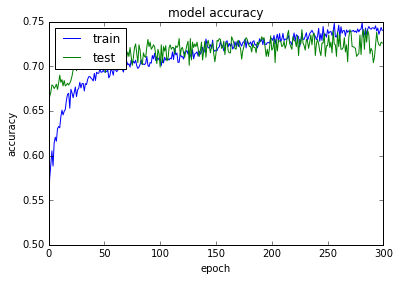

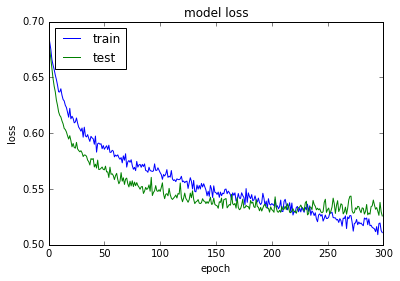

In [14]:
plot_history(history)

In [15]:
get_test_acc(test_x_cat,test_y,model_cnn)

4960/5000 [============================>.] - ETA: 0s

0.73180000000000001